In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_rows = 999

import random
random.seed(7)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse
from skopt.space import Real, Categorical, Integer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from skopt import BayesSearchCV





In [2]:
aisles = pd.read_csv('aisles.csv')

In [3]:
departments = pd.read_csv('departments.csv')

In [4]:
orders = pd.read_csv('orders.csv')

In [5]:
products = pd.read_csv('products.csv')

In [6]:
order_products_train = pd.read_csv('order_products__train.csv')

In [7]:
order_products_prior = pd.read_csv('order_products__prior.csv')

In [8]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [9]:
aisles.dtypes

aisle_id     int64
aisle       object
dtype: object

In [10]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [11]:
departments.dtypes

department_id     int64
department       object
dtype: object

In [12]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [13]:
products.describe(include='all')

,product_id,product_name,aisle_id,department_id
count,49688.000000,49688,49688.000000,49688.000000
unique,NaN,49688,NaN,NaN
top,NaN,Original Pancakes & Sausage On a Stick,NaN,NaN
freq,NaN,1,NaN,NaN
mean,24844.500000,NaN,67.769582,11.728687
std,14343.834425,NaN,38.316162,5.850410
min,1.000000,NaN,1.000000,1.000000
25%,12422.750000,NaN,35.000000,7.000000
50%,24844.500000,NaN,69.000000,13.000000
75%,37266.250000,NaN,100.000000,17.000000


In [14]:
products.dtypes

product_id        int64
product_name     object
aisle_id          int64
department_id     int64
dtype: object

In [15]:
products_org = pd.merge(products, departments, how = 'inner' , on = 'department_id', suffixes = ['p', 'd'])

In [16]:
products_org['department'].unique()

array(['snacks', 'pantry', 'beverages', 'frozen', 'personal care',
       'dairy eggs', 'household', 'babies', 'meat seafood',
       'dry goods pasta', 'pets', 'breakfast', 'canned goods', 'produce',
       'missing', 'international', 'deli', 'alcohol', 'bakery', 'other',
       'bulk'], dtype=object)

In [17]:
product_organized = pd.merge(products_org, aisles, how = 'inner', on = 'aisle_id', suffixes = ['p', 'a'])

In [18]:
product_organized.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,snacks,cookies cakes
2,102,Danish Butter Cookies,61,19,snacks,cookies cakes
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,snacks,cookies cakes
4,285,Mini Nilla Wafers Munch Pack,61,19,snacks,cookies cakes


In [19]:
print(aisles.isnull().sum())
print(departments.isnull().sum())
print(orders.isnull().sum())
print(products.isnull().sum())
print(order_products_train.isnull().sum())
print(order_products_prior.isnull().sum())

aisle_id    0
aisle       0
dtype: int64
department_id    0
department       0
dtype: int64
order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64
product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64


In [20]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [21]:
orders['eval_set'].unique()

array(['prior', 'train', 'test'], dtype=object)

In [22]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [23]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [24]:
test = orders[orders['eval_set'] == 'test']

In [25]:
test.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
53,1528013,6,test,4,3,16,22.0
96,1376945,11,test,8,6,11,8.0
102,1356845,12,test,6,1,20,30.0


In [26]:
prior_orders = pd.merge(order_products_prior, orders, how = 'inner', on = 'order_id', suffixes = ['prior', 'o'])

In [27]:
prior_orders.describe(include='all')

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3.243449e+07,3.243449e+07,3.243449e+07,3.243449e+07,3.243449e+07,32434489,3.243449e+07,3.243449e+07,3.243449e+07,3.035642e+07
unique,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,prior,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,32434489,NaN,NaN,NaN,NaN
mean,1.710749e+06,2.557634e+04,8.351076e+00,5.896975e-01,1.029372e+05,NaN,1.714205e+01,2.738818e+00,1.342498e+01,1.110407e+01
std,9.873007e+05,1.409669e+04,7.126671e+00,4.918886e-01,5.946648e+04,NaN,1.753504e+01,2.090049e+00,4.246365e+00,8.778914e+00
min,2.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,NaN,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.559430e+05,1.353000e+04,3.000000e+00,0.000000e+00,5.142100e+04,NaN,5.000000e+00,1.000000e+00,1.000000e+01,5.000000e+00
50%,1.711048e+06,2.525600e+04,6.000000e+00,1.000000e+00,1.026110e+05,NaN,1.100000e+01,3.000000e+00,1.300000e+01,8.000000e+00
75%,2.565514e+06,3.793500e+04,1.100000e+01,1.000000e+00,1.543910e+05,NaN,2.400000e+01,5.000000e+00,1.600000e+01,1.500000e+01


In [28]:
prior_orders.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


In [29]:
train = pd.merge(order_products_train, orders, how = 'inner', on = 'order_id', suffixes = ['train', 'o'])

In [30]:
train.describe(include='all')

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,1.384617e+06,1.384617e+06,1.384617e+06,1.384617e+06,1.384617e+06,1384617,1.384617e+06,1.384617e+06,1.384617e+06,1.384617e+06
unique,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,train,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,1384617,NaN,NaN,NaN,NaN
mean,1.706298e+06,2.555624e+04,8.758044e+00,5.985944e-01,1.031128e+05,NaN,1.709141e+01,2.701392e+00,1.357759e+01,1.706613e+01
std,9.897326e+05,1.412127e+04,7.423936e+00,4.901829e-01,5.948715e+04,NaN,1.661404e+01,2.167646e+00,4.238458e+00,1.042642e+01
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,NaN,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.433700e+05,1.338000e+04,3.000000e+00,0.000000e+00,5.173200e+04,NaN,6.000000e+00,1.000000e+00,1.000000e+01,7.000000e+00
50%,1.701880e+06,2.529800e+04,7.000000e+00,1.000000e+00,1.029330e+05,NaN,1.100000e+01,3.000000e+00,1.400000e+01,1.500000e+01
75%,2.568023e+06,3.794000e+04,1.200000e+01,1.000000e+00,1.549590e+05,NaN,2.100000e+01,5.000000e+00,1.700000e+01,3.000000e+01


In [31]:
train.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,112108,train,4,4,10,9.0
1,1,11109,2,1,112108,train,4,4,10,9.0
2,1,10246,3,0,112108,train,4,4,10,9.0
3,1,49683,4,0,112108,train,4,4,10,9.0
4,1,43633,5,1,112108,train,4,4,10,9.0


In [32]:
product_organized.isnull().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
department       0
aisle            0
dtype: int64

In [33]:
prior_orders.isnull().sum()

order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
dtype: int64

In [34]:
train.isnull().sum()

order_id                  0
product_id                0
add_to_cart_order         0
reordered                 0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
dtype: int64

In [35]:
prior = pd.merge(prior_orders, product_organized, how = 'inner', on = 'product_id', suffixes = ['prior', 'product'])

In [36]:
post = pd.merge(train, product_organized, how = 'inner', on = 'product_id', suffixes = ['train', 'product'])

In [37]:
test.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
53,1528013,6,test,4,3,16,22.0
96,1376945,11,test,8,6,11,8.0
102,1356845,12,test,6,1,20,30.0


In [38]:
prior.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,department,aisle
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,dairy eggs,eggs
1,26,33120,5,0,153404,prior,2,0,16,7.0,Organic Egg Whites,86,16,dairy eggs,eggs
2,120,33120,13,0,23750,prior,11,6,8,10.0,Organic Egg Whites,86,16,dairy eggs,eggs
3,327,33120,5,1,58707,prior,21,6,9,8.0,Organic Egg Whites,86,16,dairy eggs,eggs
4,390,33120,28,1,166654,prior,48,0,12,9.0,Organic Egg Whites,86,16,dairy eggs,eggs


In [39]:
post.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,department,aisle
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16,dairy eggs,yogurt
1,816049,49302,7,1,47901,train,14,4,6,16.0,Bulgarian Yogurt,120,16,dairy eggs,yogurt
2,1242203,49302,1,1,2993,train,15,0,7,7.0,Bulgarian Yogurt,120,16,dairy eggs,yogurt
3,1383349,49302,11,1,41425,train,4,3,8,14.0,Bulgarian Yogurt,120,16,dairy eggs,yogurt
4,1787378,49302,8,0,187205,train,5,4,14,30.0,Bulgarian Yogurt,120,16,dairy eggs,yogurt


In [40]:
# concatenate prior and post for stats
frames = [prior, post]
data = pd.concat(frames)

In [41]:
print(prior.shape, post.shape, data.shape)

(32434489, 15) (1384617, 15) (33819106, 15)


### Classification for Reordered or Not

In [42]:
#data.dtypes

In [43]:
#cat_attribs = ['product_name', 'department', 'aisle']
#               
#num_attribs = ['add_to_cart_order', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']
#
#label = 'reordered'

In [44]:
#data['days_since_prior_order'].isnull().sum()

In [45]:
### data = data.iloc[0:1000, :]

In [46]:
#collist = data.columns

In [47]:
#cols = [collist[4], collist[0], collist[1], collist[11], collist[12], collist[5], collist[2], collist[6], collist[7], \
#       collist[8], collist[9], collist[10], collist[13], collist[14],collist[3]]

In [48]:
#data = data[cols]

In [49]:
#data.duplicated().sum()

In [50]:
#data_training = prior[cols]
#data_test = post[cols]

In [51]:
#print(data_training.shape)
#print(data_test.shape)

In [52]:
#class CategoricalEncoder(BaseEstimator, TransformerMixin):
#    """Encode categorical features as a numeric array.
#    The input to this transformer should be a matrix of integers or strings,
#    denoting the values taken on by categorical (discrete) features.
#    The features can be encoded using a one-hot aka one-of-K scheme
#    (``encoding='onehot'``, the default) or converted to ordinal integers
#    (``encoding='ordinal'``).
#    This encoding is needed for feeding categorical data to many scikit-learn
#    estimators, notably linear models and SVMs with the standard kernels.
#    Parameters
#    ----------
#    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
#        The type of encoding to use (default is 'onehot'):
#        - 'onehot': encode the features using a one-hot aka one-of-K scheme
#          (or also called 'dummy' encoding). This creates a binary column for
#          each category and returns a sparse matrix.
#        - 'onehot-dense': the same as 'onehot' but returns a dense array
#          instead of a sparse matrix.
#        - 'ordinal': encode the features as ordinal integers. This results in
#          a single column of integers (0 to n_categories - 1) per feature.
#    categories : 'auto' or a list of lists/arrays of values.
#        Categories (unique values) per feature:
#        - 'auto' : Determine categories automatically from the training data.
#        - list : ``categories[i]`` holds the categories expected in the ith
#          column. The passed categories are sorted before encoding the data
#          (used categories can be found in the ``categories_`` attribute).
#    dtype : number type, default np.float64
#        Desired dtype of output.
#    handle_unknown : 'error' (default) or 'ignore'
#        Whether to raise an error or ignore if a unknown categorical feature is
#        present during transform (default is to raise). When this is parameter
#        is set to 'ignore' and an unknown category is encountered during
#        transform, the resulting one-hot encoded columns for this feature
#        will be all zeros.
#        Ignoring unknown categories is not supported for
#        ``encoding='ordinal'``.
#    Attributes
#    ----------
#    categories_ : list of arrays
#        The categories of each feature determined during fitting. When
#        categories were specified manually, this holds the sorted categories
#        (in order corresponding with output of `transform`).
#    """
#
#    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
#                 handle_unknown='ignore'):
#        self.encoding = encoding
#        self.categories = categories
#        self.dtype = dtype
#        self.handle_unknown = handle_unknown
#
#    def fit(self, X, y=None):
#        """Fit the CategoricalEncoder to X.
#        Parameters
#        ----------
#        X : array-like, shape [n_samples, n_feature]
#            The data to determine the categories of each feature.
#        Returns
#        -------
#        self
#        """
#
#        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
#            template = ("encoding should be either 'onehot', 'onehot-dense' "
#                        "or 'ordinal', got %s")
#            raise ValueError(template % self.handle_unknown)
#
#        if self.handle_unknown not in ['error', 'ignore']:
#            template = ("handle_unknown should be either 'error' or "
#                        "'ignore', got %s")
#            raise ValueError(template % self.handle_unknown)
#
#        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
#            raise ValueError("handle_unknown='ignore' is not supported for"
#                             " encoding='ordinal'")
#
#        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
#        n_samples, n_features = X.shape
#
#        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]
#
#        for i in range(n_features):
#            le = self._label_encoders_[i]
#            Xi = X[:, i]
#            if self.categories == 'auto':
#                le.fit(Xi)
#            else:
#                valid_mask = np.in1d(Xi, self.categories[i])
#                if not np.all(valid_mask):
#                    if self.handle_unknown == 'error':
#                        diff = np.unique(Xi[~valid_mask])
#                        msg = ("Found unknown categories {0} in column {1}"
#                               " during fit".format(diff, i))
#                        raise ValueError(msg)
#                le.classes_ = np.array(np.sort(self.categories[i]))
#
#        self.categories_ = [le.classes_ for le in self._label_encoders_]
#
#        return self
#
#    def transform(self, X):
#        """Transform X using one-hot encoding.
#        Parameters
#        ----------
#        X : array-like, shape [n_samples, n_features]
#            The data to encode.
#        Returns
#        -------
#        X_out : sparse matrix or a 2-d array
#            Transformed input.
#        """
#        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
#        n_samples, n_features = X.shape
#        X_int = np.zeros_like(X, dtype=np.int)
#        X_mask = np.ones_like(X, dtype=np.bool)
#
#        for i in range(n_features):
#            valid_mask = np.in1d(X[:, i], self.categories_[i])
#
#            if not np.all(valid_mask):
#                if self.handle_unknown == 'error':
#                    diff = np.unique(X[~valid_mask, i])
#                    msg = ("Found unknown categories {0} in column {1}"
#                           " during transform".format(diff, i))
#                    raise ValueError(msg)
#                else:
#                    # Set the problematic rows to an acceptable value and
#                    # continue `The rows are marked `X_mask` and will be
#                    # removed later.
#                    X_mask[:, i] = valid_mask
#                    X[:, i][~valid_mask] = self.categories_[i][0]
#            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])
#
#        if self.encoding == 'ordinal':
#            return X_int.astype(self.dtype, copy=False)
#
#        mask = X_mask.ravel()
#        n_values = [cats.shape[0] for cats in self.categories_]
#        n_values = np.array([0] + n_values)
#        indices = np.cumsum(n_values)
#
#        column_indices = (X_int + indices[:-1]).ravel()[mask]
#        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
#                                n_features)[mask]
#        data = np.ones(n_samples * n_features)[mask]
#
#        out = sparse.csc_matrix((data, (row_indices, column_indices)),
#                                shape=(n_samples, indices[-1]),
#                                dtype=self.dtype).tocsr()
#        if self.encoding == 'onehot-dense':
#            return out.toarray()
#        else:
#            return out
#
#class DataFrameSelector(BaseEstimator, TransformerMixin):
#    def __init__(self, attribute_names):
#        self.attribute_names = attribute_names
#    def fit(self, X, y=None):
#        return self
#    def transform(self, X):
#        return X[self.attribute_names].values
#    def get_feature_names(self):
#        return self.columns.tolist()
#    
#class DataFrameImputer(TransformerMixin):
#    def __init__(self, attribute_names):
#        self.attribute_names = attribute_names
#
#    
#    def fit(self, X, y=None):
#
#        self.fill = pd.Series([X[c].value_counts().index[0]
#            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
#            index=X.columns)
#
#        return self
#
#    def transform(self, X, y=None):
#        return X.fillna(self.fill)

In [53]:
#num_pipeline = Pipeline([
#    ('selector', DataFrameSelector(num_attribs)),
#    ('imputer', Imputer(strategy='median')),
#    ('scale', StandardScaler())
#])
#
#cat_pipeline = Pipeline([
#    ('selector', DataFrameSelector(cat_attribs)),
#    ('encoding', CategoricalEncoder()),
#])
#
#feature_union = FeatureUnion([
#    ('num_pipe', num_pipeline),
#    ('cat_pipe', cat_pipeline)
#])
#
#full_pipeline = Pipeline([
#    ('union', feature_union),
#    ('model', LogisticRegression()),
#])

In [54]:
#features = num_attribs + cat_attribs

In [55]:
#data['reordered'].sum()/data['reordered'].count()

In [56]:
#model = full_pipeline.fit(data_training, data_training[label])

In [57]:
#predictions = model.predict(data_test) 

In [58]:
#LRscore = model.score(data_test, data_test[label])

In [59]:
#print('Logistic Regression prediction accuracy is', LRscore)

### Grid Search - Model Selection

In [60]:
#lr_search = {
#    'model': Categorical([LogisticRegression()]),
#    'model__penalty': Categorical(['l1','l2']),
#    'model__C': Real(1E-12,1, prior='uniform')
#}
#
#
#rf_search = {
#    'model': Categorical([RandomForestClassifier(n_estimators=100)]),
#    'model__max_depth': Integer(3,12)
#}

In [61]:
#search_spaces =  [(lr_search, 12), (rf_search, 12)]
#
#
#gs = BayesSearchCV(estimator=full_pipeline, 
#                   search_spaces=search_spaces,
#                   scoring='roc_auc',
#                   cv = 5, 
#                   refit=True)

In [62]:
#gs.fit(data_training, data_training[label])

In [63]:
#gs.best_estimator_.named_steps

In [64]:
#rf_predictions = gs.score(test, test[label])
#print('Best estimator, Random Forest, performance', rf_predictions, 'optimized for AUC')

In [65]:
#print(classification_report(test[label], gs.predict(test)))

### Question 1)

Instacart advertises itself as a convenient way of **grocery shopping and delivery system**. Let's understand if Instacart should invest in engaging more customers for a shopping experience beyond groceries. 

> Does Instacart's **grocery shopping and delivery system** branding affect the reordering of certain products? 

> Do shoppers mostly order groceries instead of, for instance, personal care? 

> What type of items exist together in an order that has most repetitive orders? Groceries, or personal care? 

> Is there a potential group of users who order personal products only?

In [66]:
def plot_hist(d):
    plt.bar(d.keys(), d.values(), color='g')
    plt.xticks(rotation=90)
    
   

Reordering Ratio in Departments 
 department
personal care      0.321863
pantry             0.347400
international      0.369682
missing            0.394323
household          0.403339
other              0.407052
canned goods       0.458639
dry goods pasta    0.462220
frozen             0.542634
breakfast          0.561351
meat seafood       0.568625
alcohol            0.571221
snacks             0.574464
bulk               0.577090
babies             0.577680
pets               0.602557
deli               0.608130
bakery             0.628381
produce            0.650521
beverages          0.653651
dairy eggs         0.670161
Name: reordered, dtype: float64


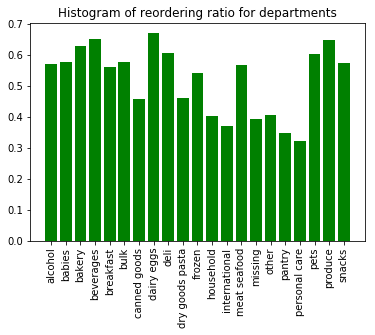

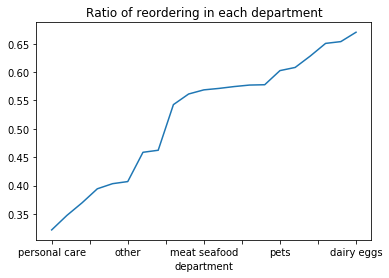

In [67]:
dep_reorders = data.groupby('department')['reordered'].sum()/data.groupby('department')['reordered'].count()
dict_dep_reorders = dep_reorders.to_dict()
plt.figure()
plot_hist(dict_dep_reorders)
plt.title('Histogram of reordering ratio for departments')

plt.figure()
dep_reorders.sort_values().plot()
plt.title('Ratio of reordering in each department')

print('Reordering Ratio in Departments', '\n', dep_reorders.sort_values())

Total orders in Departments 
 department
bulk                 35932
other                38086
missing              77396
pets                102221
alcohol             159294
international       281155
babies              438743
personal care       468693
breakfast           739069
meat seafood        739238
household           774652
dry goods pasta     905340
deli               1095540
canned goods       1114857
bakery             1225181
pantry             1956819
frozen             2336858
beverages          2804175
snacks             3006412
dairy eggs         5631067
produce            9888378
Name: reordered, dtype: int64


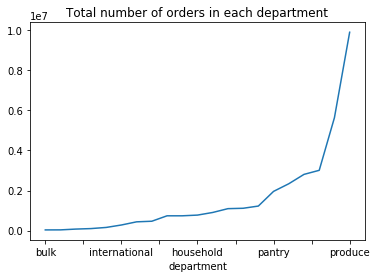

In [68]:
dep_orders = data.groupby('department')['reordered'].count()

plt.figure()
dep_orders.sort_values().plot()
plt.title('Total number of orders in each department')

print('Total orders in Departments', '\n', dep_orders.sort_values())

In [69]:
df_dep_orders = dep_orders.to_frame(name='tot_orders')
df_dep_orders = df_dep_orders.reset_index()

In [70]:
df_dep_orders

,department,tot_orders
0,alcohol,159294
1,babies,438743
2,bakery,1225181
3,beverages,2804175
4,breakfast,739069
5,bulk,35932
6,canned goods,1114857
7,dairy eggs,5631067
8,deli,1095540
9,dry goods pasta,905340


In [71]:
df_dep_orders['quan'] = 0
q1 = df_dep_orders.quantile(0.25)['tot_orders']
q2 = df_dep_orders.quantile(0.5)['tot_orders']
q3 = df_dep_orders.quantile(0.75)['tot_orders']
q4 = df_dep_orders.quantile(1)['tot_orders']
cntr = 0

for c in df_dep_orders['tot_orders']:
    if c < q1:
        df_dep_orders.quan[cntr] = 1
    elif q1 <= c < q2:
        df_dep_orders.quan[cntr] = 2
    elif df_dep_orders.quantile(0.5)['tot_orders'] <= c < df_dep_orders.quantile(0.75)['tot_orders']:
        df_dep_orders.quan[cntr]= 3
    else:
        df_dep_orders.quan[cntr] = 4
    cntr += 1

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWa

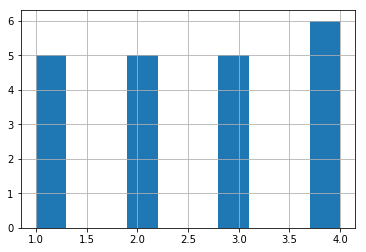

In [72]:
df_dep_orders.quan.hist()

Almost equal distribution of (number of) products in all quantiles

In [73]:
df_dep_orders.groupby('quan')['tot_orders'].sum()

quan
1      412929
2     2666898
3     5115570
4    25623709
Name: tot_orders, dtype: int64

Though there are (almost) equal number of products in all quartiles, the total number of orders vary. (Obviously)

In [74]:
df_dep_orders.sort_values(by = ['quan', 'tot_orders'])

,department,tot_orders,quan
5,bulk,35932,1
15,other,38086,1
14,missing,77396,1
18,pets,102221,1
0,alcohol,159294,1
12,international,281155,2
1,babies,438743,2
17,personal care,468693,2
4,breakfast,739069,2
13,meat seafood,739238,2


Alcohol (in quantile 1) can be considered groceries but this may change by state regulations, since in some states alcohol can only be bought from liquor shops.  

Though pantry made it to quantile 4 from the bottom of the list, It is clearly seen that groceries are certainly a big part of the orders. 

### data.head()

In [75]:
d = data.groupby(['user_id','product_id'])['reordered'].sum()
df = d.to_frame()
df = df.reset_index()

In [76]:
no_reorder = df[df['reordered'] == 0]

In [77]:
no_reordered_products = pd.merge(no_reorder, product_organized, how = 'inner', on = 'product_id', suffixes = ['no', 'pro'])

One time orders in Departments 
 department
bulk                  9575
other                17057
pets                 23365
missing              33468
alcohol              43038
babies              110206
international       133853
meat seafood        186846
breakfast           196174
deli                245158
personal care       248198
bakery              255598
dry goods pasta     326110
household           334491
canned goods        405981
beverages           545034
frozen              666034
snacks              775284
dairy eggs          977897
pantry              980859
produce            1785040
Name: user_id, dtype: int64


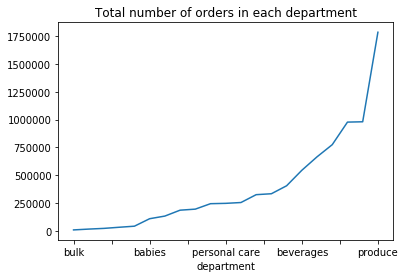

In [78]:
no_orders = no_reordered_products.groupby('department')['user_id'].count()

plt.figure()
no_orders.sort_values().plot()
plt.title('Total number of orders in each department')

print('One time orders in Departments', '\n', no_orders.sort_values())

So pantry was one of the most ordered departments that was in the 4th quantile, we see that it doesn't have repetitive orders here. 

Reordering Bulk?

In [79]:
data.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,department,aisle
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,dairy eggs,eggs
1,26,33120,5,0,153404,prior,2,0,16,7.0,Organic Egg Whites,86,16,dairy eggs,eggs
2,120,33120,13,0,23750,prior,11,6,8,10.0,Organic Egg Whites,86,16,dairy eggs,eggs
3,327,33120,5,1,58707,prior,21,6,9,8.0,Organic Egg Whites,86,16,dairy eggs,eggs
4,390,33120,28,1,166654,prior,48,0,12,9.0,Organic Egg Whites,86,16,dairy eggs,eggs


In [82]:
data['department'].unique()

array(['dairy eggs', 'produce', 'pantry', 'meat seafood', 'bakery',
       'personal care', 'snacks', 'breakfast', 'beverages', 'deli',
       'household', 'international', 'dry goods pasta', 'frozen',
       'canned goods', 'babies', 'pets', 'alcohol', 'bulk', 'missing',
       'other'], dtype=object)

In [ ]:
data.groupby('deparment')['reordered'].count()